<a href="https://colab.research.google.com/github/THANNAGA/Lagrangian/blob/main/logistic_regression_lagrangian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

!pip install git+https://github.com/cooper-org/cooper.git
import cooper
from copy import deepcopy as copy

  Cloning https://github.com/cooper-org/cooper.git to /tmp/pip-req-build-9uz7e52l
  Running command git clone --filter=blob:none --quiet https://github.com/cooper-org/cooper.git /tmp/pip-req-build-9uz7e52l
  Resolved https://github.com/cooper-org/cooper.git to commit eae7c5a68563b83410913c8b24e99b70e32694f3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [135]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.input_dim = input_dim
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        outputs = self.linear(x)
        return outputs


class NormConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to have norm less than or equal to 1
        # g(W) <= 1  ---> g(W) - 1 <= 0
        ineq_defect = model.linear.weight.norm(dim=1) - 1

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=None)

class SumConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to sum to a negative
        # g(W) <= 0
        ineq_defect = model.linear.weight.sum(dim=1)

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=None)

class TemplateConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets, template):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want the sign of W to be equal to a template T.
        # g(W) == T ---> g(W) - T == 0
        eq_defect = (model.linear.weight.sign() - template).sum()

        return cooper.CMPState(loss=loss, ineq_defect=None, eq_defect=eq_defect)

class TemplateSumConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets, template):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to sum to a negative
        # g(W) <= 0
        ineq_defect = model.linear.weight.sum(dim=1)

        # We want the sign of W to be equal to a template T.
        # g(W) == T ---> g(W) - T == 0
        eq_defect = (model.linear.weight.sign() - template).sum()

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=eq_defect)

In [136]:
dataset = MNIST(os.getcwd() + "/data", download=True, transform=transforms.ToTensor())
train_set, val_set = random_split(dataset, [55000, 5000])

In [137]:
#cmp = NormConstrainedLogReg(); equality = False
#cmp = SumConstrainedLogReg(); equality = False
cmp = TemplateConstrainedLogReg(); equality = True
formulation = cooper.LagrangianFormulation(cmp)

model = LogisticRegression(784, 10)

# primal_optimizer = cooper.optim.ExtraSGD(model.parameters(), lr=1e-3, momentum=0.9)
# dual_optimizer = cooper.optim.partial_optimizer(cooper.optim.ExtraSGD, lr=5e-3)

primal_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
dual_optimizer = cooper.optim.partial_optimizer(torch.optim.SGD, lr=5e-3)

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

for an inequalilty constraint:

In [138]:
if not equality:
  iter_num = 0

  state_history = OrderedDict()

  template = torch.randint(-1,1,(784, 10))

  for epoch in range(3):
      for inputs, targets in DataLoader(train_set, batch_size=64):

          coop.zero_grad()
          lagrangian = formulation.composite_objective(
              cmp.closure, model, inputs, targets
          )
          formulation.custom_backward(lagrangian)
          coop.step(cmp.closure, model, inputs, targets)

          if iter_num % 5 == 0:
              state_history[iter_num] = {
                  "cmp": cmp.state,
                  "dual": copy(formulation.state()),
              }

          iter_num += 1

with a weight sign template (leading to an equalilty constraint)

In [139]:
if equality:
  iter_num = 0

  state_history = OrderedDict()

  template = torch.randint(-1,1,(10, 784))

  for epoch in range(3):
      for inputs, targets in DataLoader(train_set, batch_size=64):

          coop.zero_grad()
          lagrangian = formulation.composite_objective(
              cmp.closure, model, inputs, targets, template
          )
          formulation.custom_backward(lagrangian)
          coop.step(cmp.closure, model, inputs, targets, template)

          if iter_num % 5 == 0:
              state_history[iter_num] = {
                  "cmp": cmp.state,
                  "dual": copy(formulation.state()),
              }

          iter_num += 1

For an inequality constraint:

In [140]:
if not equality:

  iters, loss_history = zip(
      *[(iter_num, _["cmp"].loss.item()) for (iter_num, _) in state_history.items()]
  )
  mult_hist = np.stack(
      [_["dual"][0].data.numpy() for (foo, _) in state_history.items()], axis=1
  )
  defect_hist = np.stack(
      [_["cmp"].ineq_defect.data.numpy() for (foo, _) in state_history.items()], axis=1
  )

For an equality constraint:

In [141]:
if equality:
  iters, loss_history = zip(
      *[(iter_num, _["cmp"].loss.item()) for (iter_num, _) in state_history.items()]
  )

  #for (foo, _) in state_history.items():
  #  print (foo, _)
  print (_["dual"])
  mult_hist = [_["dual"][1].data.numpy() for (foo, _) in state_history.items()]
  defect_hist = [_["cmp"].eq_defect.data.numpy() for (foo, _) in state_history.items()]

0 {'cmp': CMPState(loss=tensor(2.3185, grad_fn=<NllLossBackward0>), ineq_defect=None, eq_defect=tensor(3959., grad_fn=<SumBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None), 'dual': (None, Parameter containing:
tensor(19.7950, requires_grad=True))}
5 {'cmp': CMPState(loss=tensor(2.3152, grad_fn=<NllLossBackward0>), ineq_defect=None, eq_defect=tensor(3961., grad_fn=<SumBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None), 'dual': (None, Parameter containing:
tensor(118.7800, requires_grad=True))}
10 {'cmp': CMPState(loss=tensor(2.3073, grad_fn=<NllLossBackward0>), ineq_defect=None, eq_defect=tensor(3959., grad_fn=<SumBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None), 'dual': (None, Parameter containing:
tensor(217.8650, requires_grad=True))}
15 {'cmp': CMPState(loss=tensor(2.2304, grad_fn=<NllLossBackward0>), ineq_defect=None, eq_defect=tensor(3957., grad_fn=<SumBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None),

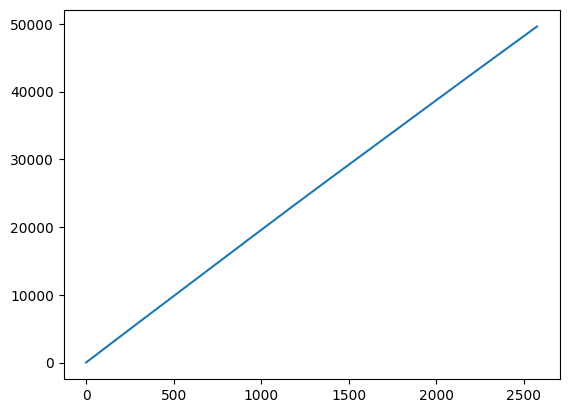

In [142]:
#inequality
if not equality:
  plt.plot(iters, mult_hist[0:1, ...].T)

#equality
if equality:
  plt.plot(iters, mult_hist)

plt.show()

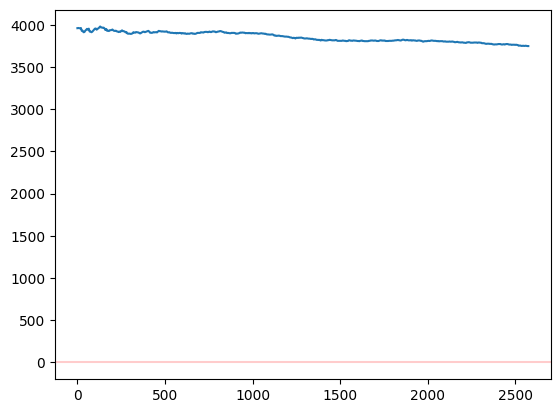

In [143]:
#inequality
if not equality:
  plt.plot(iters, defect_hist[0:1, ...].T)

#equality
if equality:
  plt.plot(iters, defect_hist)

plt.axhline(0.0, c="r", alpha=0.2)
plt.show()

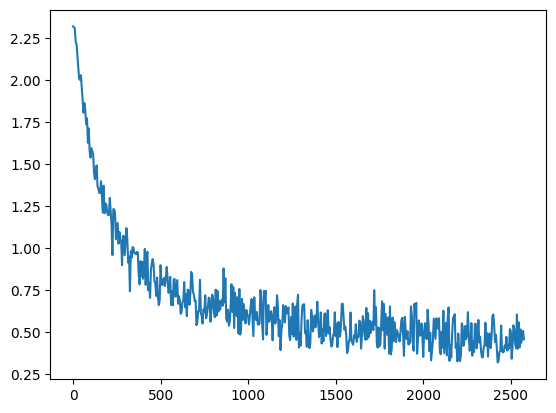

In [144]:
plt.plot(iters, loss_history)

In [145]:
total, correct = 0, 0
with torch.no_grad():
    for inputs, targets in DataLoader(val_set, batch_size=64):
        outputs = model.forward(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum()
accuracy = 100 * correct / total
accuracy

tensor(87.4000)

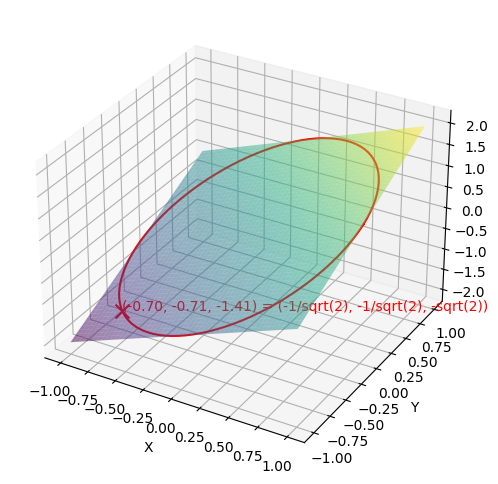

-0.7071067811865475


In [146]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of points
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
x, y = np.meshgrid(x, y)

# Compute z = f(x, y)
z = x + y

# Create a grid of points for the circle
theta = np.linspace(0, 2*np.pi, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)

# Compute z = f(x, y) for the points on the circle
z_circle = x_circle + y_circle

# Compute the angle at which x + y is minimized on the circle
theta_min = np.argmin(x_circle + y_circle)

# Get the x, y, z coordinates of this point
x_min = x_circle[theta_min]
y_min = y_circle[theta_min]
z_min = x_min + y_min

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, z, cmap='viridis', alpha=0.5)

# Plot the circle
ax.plot(x_circle, y_circle, z_circle, color='r')

# Plot the minimum point
ax.scatter([x_min], [y_min], [z_min], color='r', marker='x', s=100)

# Annotate the minimum point
if np.isclose(x_min, -1/np.sqrt(2), atol=0.01) and np.isclose(y_min, -1/np.sqrt(2), atol=0.01):
    ax.text(x_min, y_min, z_min, f'({x_min:.2f}, {y_min:.2f}, {z_min:.2f}) = (-1/sqrt(2), -1/sqrt(2), -sqrt(2))', color='r')
else:
    ax.text(x_min, y_min, z_min, f'({x_min:.2f}, {y_min:.2f}, {z_min:.2f})', color='r')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
print (-1/2**0.5)